In [27]:
import sys, os
from pathlib import Path
from addict import Dict as Adict
import pandas as pd
from pathlib import Path

sys.path.insert(0, '/home/rzhu/Desktop/projects/kinase_analysis/src/')

from MSMAnalysis import *
import mdtraj as md
from funcs_featurise import *
from funcs_indices import *
from funcs_db_assign import *
from funcs_plotting import *
from funcs_sample import *

In [2]:
protein = 'abl'
base_path = Path(f'/home/rzhu/Desktop/projects/kinase_analysis/')
hp_dict = Adict({'hp_id': 2,
                'trajlen__cutoff': 1000,
                'n__boot': 20,
                'seed': 49587,
                'tica__lag': 10,
                'tica__stride': 1000,
                'tica__dim': 20,
                'cluster__k': 1000,
                'cluster__stride': 100,
                'cluster__maxiter': 1000,
                'markov__lag': 100})
stride = 50

In [3]:
all_features = ['dbdist', 'dbdihed', 'aloop', 'achelix']

MA = MSMAnalysis(protein, trajlen_cutoff=10000)
MA.load_ftrajs(features=all_features, arc_dir=base_path/'data'/f'{protein}'/'ftrajs')

Loading feature:  dbdist


100%|██████████| 749/749 [00:00<00:00, 5865.58it/s]


Loading feature:  dbdihed


100%|██████████| 749/749 [00:00<00:00, 2807.68it/s]


Loading feature:  aloop


100%|██████████| 749/749 [00:02<00:00, 261.21it/s]


Loading feature:  achelix


100%|██████████| 749/749 [00:00<00:00, 8614.73it/s]

Features loaded: {'achelix', 'aloop', 'dbdihed', 'dbdist'}


In [4]:
dihed_cluster_labels = ['noise', 'BLAminus', 'BLAplus', 'ABAminus', 'BLBminus', 'BLBplus', 'BLBtrans', 'BABtrans', 'BBAminus']
spatial_cluster_labels = ['DFG-in', 'DFG-inter', 'DFG-out']

In [5]:
study = MA.create_study(study_name=f'striding_{stride}', 
                        hp_dict=hp_dict, 
                        features=all_features,
                        stride=stride,
                        create_new=True,
                        wk_dir=base_path/f'data/{protein}/msm/validation/striding/{stride}')
study.set_pcca(6)
study.estimate_MSM()
study.save_models()

Preparing feature trajectories...


100%|██████████| 749/749 [00:03<00:00, 224.89it/s]
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "tica". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.decomposition.TICA instead.
  return caller(func, *(extras + args), **kw)


Parameter hp_id not allowed, ignore. Check the allowed parameters
Parameter trajlen__cutoff not allowed, ignore. Check the allowed parameters
Parameter n__boot not allowed, ignore. Check the allowed parameters
Parameter seed not allowed, ignore. Check the allowed parameters
Number of metastable states not specified. Defaulting to 5. Run set_pcca() to set the number of metastable states
Set number of metastable states to  6


100%|██████████| 401/401 [00:00<00:00, 1161.46it/s]                        
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py:232: PyEMMA_DeprecationWarning: Call to deprecated function "cluster_kmeans". Called from /home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/decorator.py line 232. Use deeptime.clustering.KMeans instead.
  return caller(func, *(extras + args), **kw)
100%|██████████| 1000/1000 [00:00<00:00, 4332.14it/s]
/home/rzhu/Loc/miniconda3/envs/kinase/lib/python3.10/site-packages/numpy/core/numeric.py:330: RuntimeWarning: invalid value encountered in cast
  multiarray.copyto(a, fill_value, casting='unsafe')


MSM estimation complete


/home/rzhu/Desktop/projects/kinase_analysis/src/funcs_plotting.py:86: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[state_assignment == i, dim_1], c_centers[state_assignment == i, dim_2],
/home/rzhu/Desktop/projects/kinase_analysis/src/funcs_plotting.py:86: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(c_centers[state_assignment == i, dim_1], c_centers[state_assignment == i, dim_2],
/home/rzhu

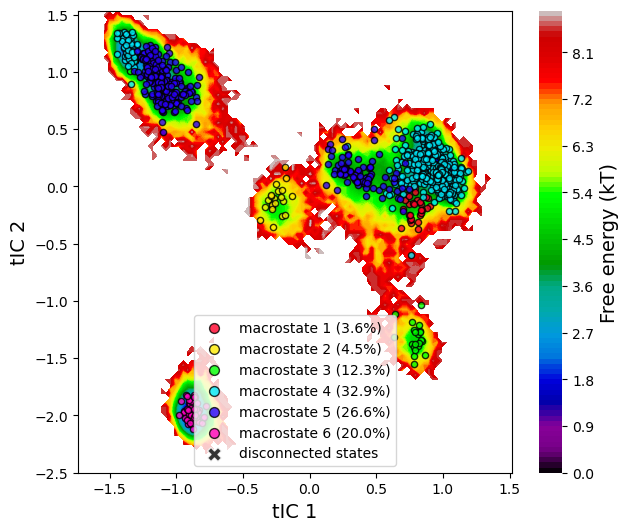

In [6]:
plot_fe(traj_all=study.ttraj_cat,
        traj_weights = np.concatenate(study.traj_weights, axis=0),
        c_centers=study.kmeans_centers[study.connected_states, :],
        c_centers_s=80,
        state_assignment=study.pcca_mod.assignments,
        state_population=study.pcca_mod.coarse_grained_stationary_probability,
        linewidth=1,
        d_centers=study.kmeans_centers[study.disconnected_states, :],
        d_centers_s=30,
        d_centers_marker='X',
        legend_marker_sizes=[200, 200, 200, 200, 200, 200, 100],
        savedir = study.fig_dir/'fes_pcca.png')

In [7]:
dbdist, _ = prepare_ftrajs(MA.select_ftrajs(features=['dbdist']), stride=stride)
dbdist_cat = np.concatenate(dbdist)
dbdihed, _ = prepare_ftrajs(MA.select_ftrajs(features=['dbdihed']), stride=stride, convert_dihed=False)
dbdihed_cat = np.concatenate(dbdihed)
sim_ptraj_cat = np.array([study.micro_to_macro[d] if d in study.connected_states else -1 for d in study.dtraj_cat])

Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 12366.15it/s]


Preparing feature trajectories...


100%|██████████| 749/749 [00:00<00:00, 4125.25it/s]


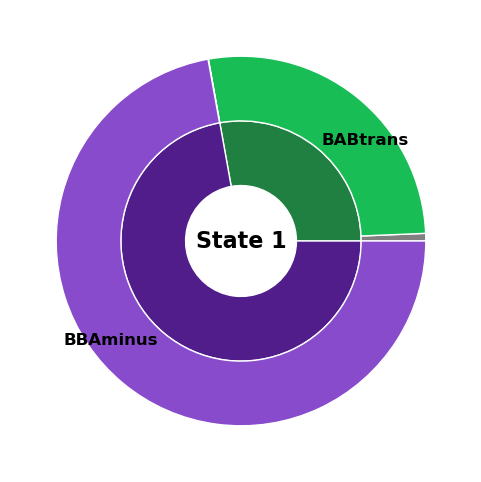

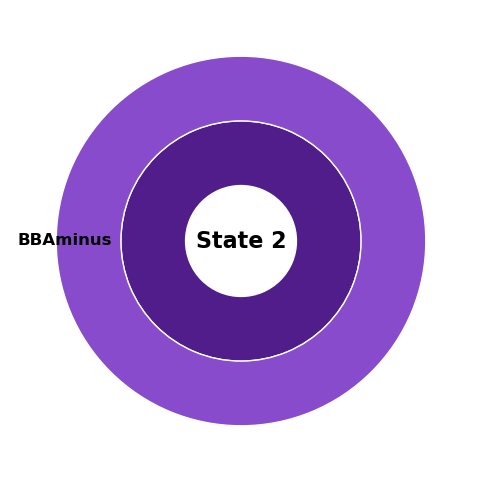

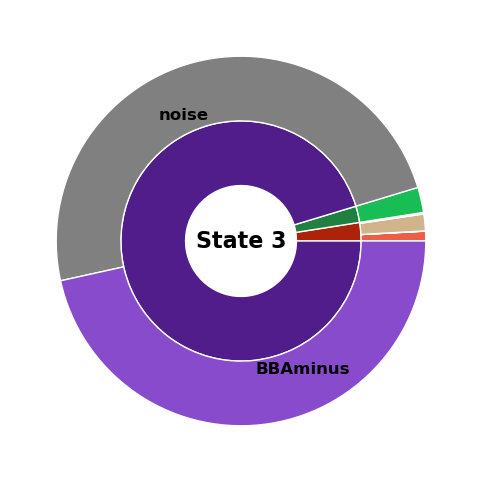

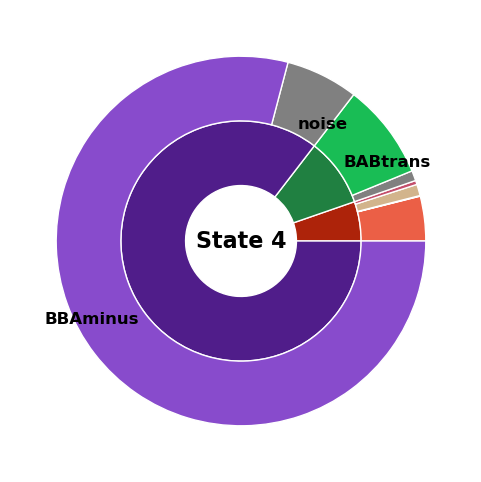

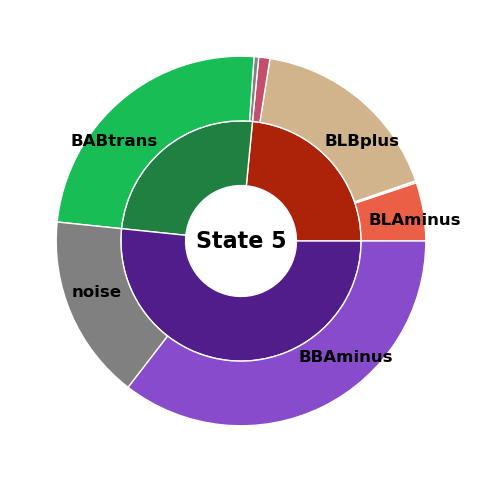

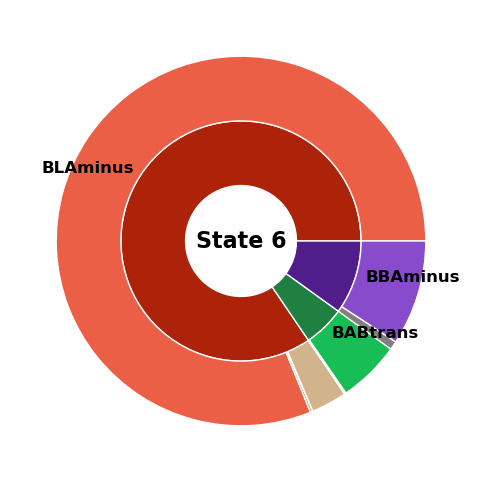

In [31]:
for state_i in range(study._pcca_n):
    frame_indices = np.where(sim_ptraj_cat == state_i)[0]
    dbdist_i, dbdihed_i = dbdist_cat[frame_indices], dbdihed_cat[frame_indices]
    spatial_assignments, dihedral_assignments = dfg_featuriser(dists=dbdist_i, diheds=dbdihed_i[:,[0,1,2,3,4,5,8]], \
                                                                    dist_centroids = np.load(base_path/f'data/{protein}/cluster_centers/dfg_spatial_centroids.npy', allow_pickle=True), 
                                                                    dihed_centroids = np.load(base_path/f'data/{protein}/cluster_centers/dfg_dihed_centroids.npy', allow_pickle=True).item(), 
                                                                    dihed_cutoff=1.5)
    spatial_counts = np.array([np.sum(spatial_assignments == i) for i in range(3)])
    in_dihed_counts = [np.sum(dihedral_assignments == i) for i in range(0,6)]
    inter_dihed_counts = [np.sum(dihedral_assignments == i) for i in range(6,7)]
    out_dihed_counts = [np.sum(dihedral_assignments == i) for i in range(7,8)]
    dihed_counts = [[spatial_counts[0] - np.sum(in_dihed_counts)] + in_dihed_counts, 
                    [spatial_counts[1] - np.sum(inter_dihed_counts)] + inter_dihed_counts, 
                    [spatial_counts[2] - np.sum(out_dihed_counts)] + out_dihed_counts]
    plot_dihed_pie(spatial_counts, dihed_counts, radius_size=0.35, show_legend=False, show_clusters=True,
                   title=f'State {state_i+1}', 
                   savedir=study.fig_dir/f'state_{state_i+1}_dihed.png')

How does MFPT change as increasing trajectory striding?

In [9]:
mfpt = np.zeros([study.pcca_n, study.pcca_n])
mfpt_std = np.zeros([study.pcca_n, study.pcca_n])

for i in range(study.pcca_n):
    for j in range(study.pcca_n):
        mfpt[i,j] = study.baymsm_mod.gather_stats('mfpt', A=study.pcca_mod.sets[i], B=study.pcca_mod.sets[j]).mean
        mfpt_std[i,j] = study.baymsm_mod.gather_stats('mfpt', A=study.pcca_mod.sets[i], B=study.pcca_mod.sets[j]).std

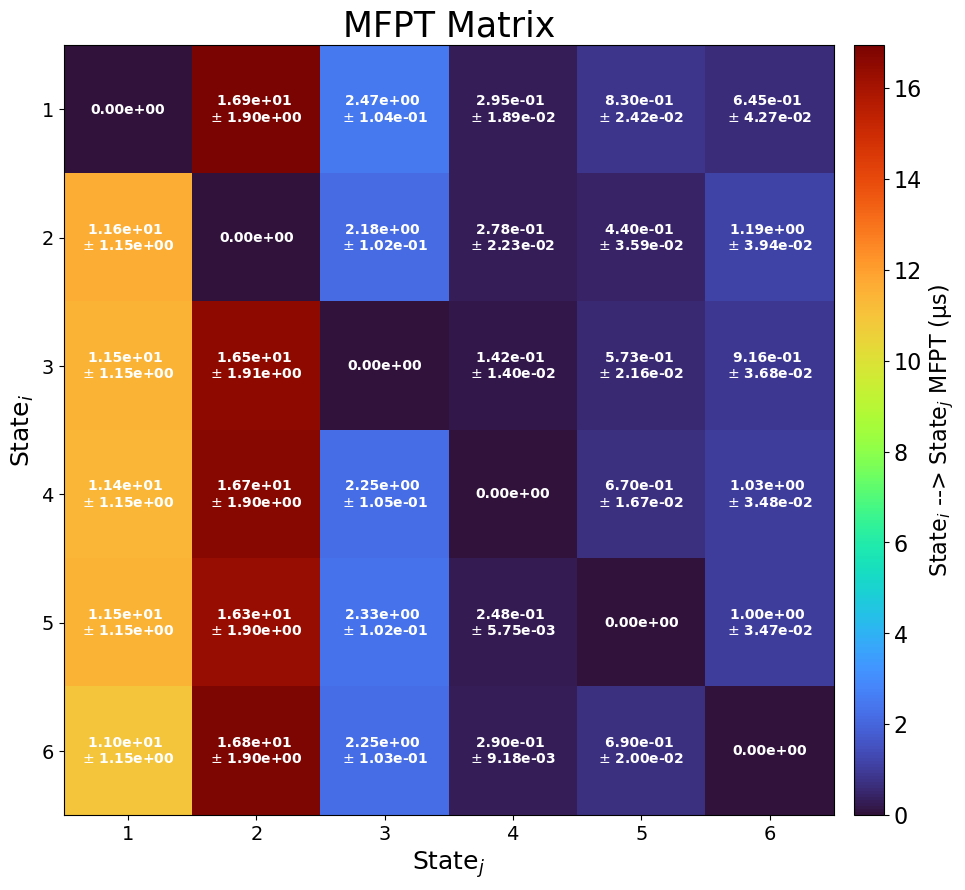

In [10]:
plot_mfpt_matrix(mfpt = mfpt, 
                 mfpt_err = mfpt_std,
                 savedir = study.fig_dir/f'mfpt_matrix.png',
                 scaling=0.00005,
                 unit="$\mathrm{\mu s}$", 
                 text_f =".2e")

In [12]:
with open(study.wk_dir/'..'/'stride_vs_mfpt.txt', 'a') as f:
    f.write(f'{stride};{mfpt[5][3]*0.00005,(mfpt_std[5][3]*0.00005)};{mfpt[3][5]*0.00005,(mfpt_std[3][5]*0.00005)}\n')

### Plot DFG-in <-> out MFPT vs stridings

---

In [13]:
data = []

with open(study.wk_dir/'..'/'stride_vs_mfpt.txt', 'r') as f:
    for line in f:
        line = line.strip()  # Remove leading/trailing whitespace/newlines
        parts = line.split(';')

        stride = int(parts[0])

        # Extract the first pair of floats
        mfpt_56_str = parts[1].strip('()')
        mfpt_56 = tuple(map(float, mfpt_56_str.split(',')))

        # Extract the second pair of floats
        mfpt_65_str = parts[2].strip('()')
        mfpt_65 = tuple(map(float, mfpt_65_str.split(',')))

        data.append((stride, *mfpt_56, *mfpt_65))

In [15]:
stride = [int(d[0]) for d in data]
mfpt_in_out = [d[1]*d[0] for d in data]
std_in_out = [d[2]*d[0] for d in data]
mfpt_out_in = [d[3]*d[0] for d in data]
std_out_in = [d[4]*d[0] for d in data]

Text(0, 0.5, 'MFPT ($\\mu s$)')

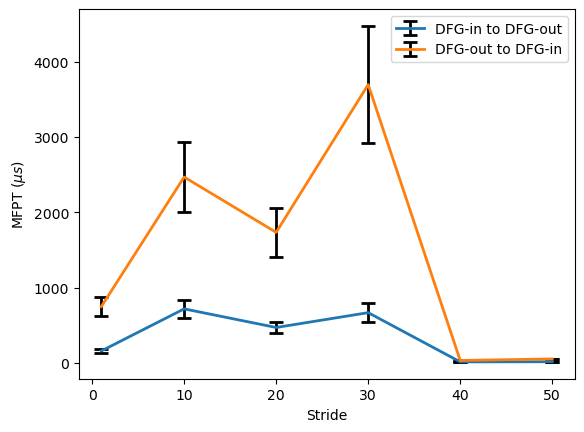

In [23]:
fig, ax = plt.subplots()
ax.errorbar(stride, mfpt_in_out, yerr=std_in_out, label='DFG-in to DFG-out', lw=2, ecolor='black', capsize=5, capthick=2)
ax.errorbar(stride, mfpt_out_in, yerr=std_out_in, label='DFG-out to DFG-in', lw=2, ecolor='black', capsize=5, capthick=2)
ax.legend()
ax.set_xlabel('Stride')
ax.set_ylabel('MFPT ($\mu s$)')